<a href="https://colab.research.google.com/github/bkrfethi/DataScience-estin-Labs/blob/main/Lab3_Cleaning_FeatureEngineering_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Fundamentals of Data Science: Lab 3
## 2CS – 2025/2026



---

### 📝 Lab Objectives:
3. **Handling Missing Values:** Imputation strategies (Mean, Median, KNN).
4. **Outlier Detection:** Z-score, Robust Z-score, IQR.
5. **Feature Generation:** Manual & Automated (Featuretools).
6. **Feature Selection:** Forward, Backward, RFE.
7. **Feature Encoding:** One-Hot, Ordinal, Target Encoding.
8. **Feature Scaling:** StandardScaler, MinMaxScaler.
9. **Dimensionality Reduction:** PCA Analysis.

---

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error


In [2]:
from google.colab import files
uploaded = files.upload()


Saving it_salary_eu_2020.csv to it_salary_eu_2020.csv


In [3]:
DATA_PATH = 'it_salary_eu_2020.csv'

df = pd.read_csv(DATA_PATH)


In [9]:
# Renommage des colonnes pour simplifier
rename_dict = {
    'Total years of experience': 'YearsExperience',
    'Yearly brutto salary (without bonus and stocks) in EUR': 'Salary',
    'Age': 'Age',
    'Gender': 'Gender',
    'City': 'City',
    'Seniority level': 'Seniority',
    'Your main technology / programming language': 'MainTech',
    'Position ': 'Position'
}
df = df.rename(columns=rename_dict)

# Conversion forcée en numérique
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')
df['YearsExperience'] = pd.to_numeric(df['YearsExperience'].astype(str).str.replace(',', '.'), errors='coerce')

# Aperçu
print("Shape:", df.shape)
display(df.head())

Shape: (1253, 23)


,Timestamp,Age,Gender,City,Position,YearsExperience,Years of experience in Germany,Seniority,MainTech,Other technologies/programming languages you use often,...,Annual bonus+stocks one year ago. Only answer if staying in same country,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Have you lost your job due to the coronavirus outbreak?,"Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week","Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR"
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5.0,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",...,10000,30,Full-time employee,Unlimited contract,English,51-100,Product,No,NaN,NaN
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7.0,4,Senior,Ruby,NaN,...,5000,28,Full-time employee,Unlimited contract,English,101-1000,Product,No,NaN,NaN
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12.0,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",...,100000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,Yes,NaN,NaN
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4.0,1,Junior,Javascript,NaN,...,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup,No,NaN,NaN
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17.0,6,Senior,C# .NET,".NET, SQL, AWS, Docker",...,NaN,29,Full-time employee,Unlimited contract,English,101-1000,Product,No,NaN,NaN


In [33]:
from sklearn.model_selection import train_test_split


possible_salary_cols = [col for col in df.columns if 'Salary' in col or 'salary' in col]
print(f"Colonnes salaire trouvées dans le fichier : {possible_salary_cols}")

if 'Salary' not in df.columns:
    if len(possible_salary_cols) > 0:
        old_name = possible_salary_cols[0]
        df = df.rename(columns={old_name: 'Salary'})
        print(f"✅ Colonne '{old_name}' renommée en 'Salary'")
    else:
        print(" ERREUR : Impossible de trouver la colonne salaire. Voici les colonnes :")
        print(df.columns.tolist())
        raise KeyError("Colonne Salaire introuvable")


# 1. Nettoyage
df_clean = df.dropna(subset=['Salary'])

# 2. Définition X (Features) et y (Target)
X = df_clean.drop('Salary', axis=1)
y = df_clean['Salary']

# 3. Split 70% Train, 15% Val, 15% Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Split réussi ! Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")

Colonnes salaire trouvées dans le fichier : ['Salary', 'Yearly brutto salary (without bonus and stocks) one year ago. Only answer if staying in same country']
Split réussi ! Train: (693, 22) | Val: (148, 22) | Test: (149, 22)


In [35]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer

print("\n-- REPARATION DES COLONNES ---")

def fix_column_names(df_in):
    # On cherche la colonne qui contient 'experience'
    exp_cols = [c for c in df_in.columns if 'experience' in c.lower()]
    if exp_cols:
        print(f"Correction : Renommage de '{exp_cols[0]}' -> 'YearsExperience'")
        df_in = df_in.rename(columns={exp_cols[0]: 'YearsExperience'})

    # On cherche la colonne 'Age'
    age_cols = [c for c in df_in.columns if 'age' in c.lower() and 'language' not in c.lower()]
    if age_cols and age_cols[0] != 'Age':
        df_in = df_in.rename(columns={age_cols[0]: 'Age'})

    return df_in

# 2. Application de la réparation
X_train = fix_column_names(X_train)
X_val = fix_column_names(X_val)
X_test = fix_column_names(X_test)

# --- 3. HANDLING MISSING VALUES  ---
print("\n--- 3. HANDLING MISSING VALUES ---")

# Vérification que la colonne cible existe maintenant
target_col = 'YearsExperience'
if target_col not in X_train.columns:
    # Cas désespéré : on crée une colonne factice pour éviter le crash si le CSV est corrompu
    print(f"⚠️ Attention : Colonne '{target_col}' introuvable. Création d'une colonne vide.")
    X_train[target_col] = 0
    X_val[target_col] = 0
    X_test[target_col] = 0

results = []

# --- Stratégie A : Listwise Deletion (Supprimer les lignes) ---
# On fait attention aux index pour aligner y_train
try:
    X_listwise = X_train.dropna()
    y_listwise = y_train.loc[X_listwise.index]
    results.append({
        'Method': 'Listwise Deletion',
        'Mean Salary': y_listwise.mean(),
        'Mean Experience': X_listwise[target_col].mean(),
        'Data Size': len(X_listwise)
    })
except Exception as e:
    print(f"Note: Listwise deletion skipped ({e})")

# Identification des colonnes numériques pour l'imputation
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

# --- Stratégie B : Mean Imputation ---
imputer_mean = SimpleImputer(strategy='mean')
X_mean = X_train.copy()
# On impute
X_mean[num_cols] = imputer_mean.fit_transform(X_mean[num_cols])
results.append({
    'Method': 'Mean Imputation',
    'Mean Salary': y_train.mean(),
    'Mean Experience': X_mean[target_col].mean(),
    'Data Size': len(X_mean)
})

# --- Stratégie C : Median Imputation ---
imputer_median = SimpleImputer(strategy='median')
X_median = X_train.copy()
X_median[num_cols] = imputer_median.fit_transform(X_median[num_cols])
results.append({
    'Method': 'Median Imputation',
    'Mean Salary': y_train.mean(),
    'Mean Experience': X_median[target_col].mean(),
    'Data Size': len(X_median)
})

# --- Stratégie D : Constant Value (0) ---
imputer_const = SimpleImputer(strategy='constant', fill_value=0)
X_const = X_train.copy()
X_const[num_cols] = imputer_const.fit_transform(X_const[num_cols])
results.append({
    'Method': 'Constant (0)',
    'Mean Salary': y_train.mean(),
    'Mean Experience': X_const[target_col].mean(),
    'Data Size': len(X_const)
})

# --- Stratégie E : KNN Imputer (Sur un échantillon si trop lent) ---
# On limite à 5 colonnes numériques max pour la vitesse KNN
cols_for_knn = num_cols[:5]
imputer_knn = KNNImputer(n_neighbors=3)
X_knn = X_train.copy()
X_knn[cols_for_knn] = imputer_knn.fit_transform(X_knn[cols_for_knn])
results.append({
    'Method': 'KNN Imputer',
    'Mean Salary': y_train.mean(),
    'Mean Experience': X_knn[target_col].mean(),
    'Data Size': len(X_knn)
})

# --- Affichage des résultats ---
df_results = pd.DataFrame(results)
print("\nComparaison des méthodes d'imputation :")
display(df_results)

# --- CHOIX FINAL : MEDIANE ---
# On applique la médiane sur les vrais datasets pour continuer le TP
final_imputer = SimpleImputer(strategy='median')
X_train.loc[:, num_cols] = final_imputer.fit_transform(X_train[num_cols])
X_val.loc[:, num_cols] = final_imputer.transform(X_val[num_cols])
X_test.loc[:, num_cols] = final_imputer.transform(X_test[num_cols])

print("\n✅ Partie 3 Terminée : Imputation par Médiane appliquée.")


-- REPARATION DES COLONNES ---
Correction : Renommage de 'YearsExperience' -> 'YearsExperience'
Correction : Renommage de 'YearsExperience' -> 'YearsExperience'
Correction : Renommage de 'YearsExperience' -> 'YearsExperience'

--- 3. HANDLING MISSING VALUES ---


ValueError: Columns must be same length as key

In [38]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer

print("\n--- 3. HANDLING MISSING VALUES---")

# --- 1. FONCTION DE RÉPARATION DES NOMS ---
def fix_column_names(df_in):
    if 'YearsExperience' in df_in.columns:
        return df_in

    exp_cols = [c for c in df_in.columns if 'experience' in c.lower()]
    if exp_cols:
        print(f"Correction : Renommage de '{exp_cols[0]}' -> 'YearsExperience'")
        df_in = df_in.rename(columns={exp_cols[0]: 'YearsExperience'})

    age_cols = [c for c in df_in.columns if 'age' in c.lower() and 'language' not in c.lower()]
    if age_cols and age_cols[0] != 'Age':
        if 'Age' not in df_in.columns:
            df_in = df_in.rename(columns={age_cols[0]: 'Age'})
    return df_in

# Application de la réparation
X_train = fix_column_names(X_train)
X_val = fix_column_names(X_val)
X_test = fix_column_names(X_test)

# --- 2. NETTOYAGE DES COLONNES 100% VIDES (CRITIQUE) ---
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cols_to_drop = [col for col in num_cols if X_train[col].isnull().all()]

if cols_to_drop:
    print(f" Suppression des colonnes 100% vides (causes du crash) : {cols_to_drop}")
    X_train = X_train.drop(columns=cols_to_drop)
    X_val = X_val.drop(columns=cols_to_drop)
    X_test = X_test.drop(columns=cols_to_drop)
    num_cols = [c for c in num_cols if c not in cols_to_drop]

print(f"Colonnes numériques utilisées : {num_cols}")

# --- 3. EXECUTION DES IMPUTATIONS ---
target_col = 'YearsExperience'
if target_col not in X_train.columns:
    X_train[target_col] = 0

results = []

# A. Listwise Deletion
try:
    X_listwise = X_train.dropna()
    y_listwise = y_train.loc[X_listwise.index]
    results.append({
        'Method': 'Listwise Deletion',
        'Mean Salary': y_listwise.mean(),
        'Mean Experience': X_listwise[target_col].mean(),
        'Data Size': len(X_listwise)
    })
except Exception as e:
    print(f"Listwise deletion skipped: {e}")

# B. Mean Imputation
imputer_mean = SimpleImputer(strategy='mean')
X_mean = X_train.copy()
X_mean[num_cols] = imputer_mean.fit_transform(X_mean[num_cols])
results.append({
    'Method': 'Mean Imputation',
    'Mean Salary': y_train.mean(),
    'Mean Experience': X_mean[target_col].mean(),
    'Data Size': len(X_mean)
})

# C. Median Imputation
imputer_median = SimpleImputer(strategy='median')
X_median = X_train.copy()
X_median[num_cols] = imputer_median.fit_transform(X_median[num_cols])
results.append({
    'Method': 'Median Imputation',
    'Mean Salary': y_train.mean(),
    'Mean Experience': X_median[target_col].mean(),
    'Data Size': len(X_median)
})

# D. Constant Value
imputer_const = SimpleImputer(strategy='constant', fill_value=0)
X_const = X_train.copy()
X_const[num_cols] = imputer_const.fit_transform(X_const[num_cols])
results.append({
    'Method': 'Constant (0)',
    'Mean Salary': y_train.mean(),
    'Mean Experience': X_const[target_col].mean(),
    'Data Size': len(X_const)
})

# E. KNN Imputer
cols_knn = num_cols[:5]
imputer_knn = KNNImputer(n_neighbors=3)
X_knn = X_train.copy()
X_knn[cols_knn] = imputer_knn.fit_transform(X_knn[cols_knn])
results.append({
    'Method': 'KNN Imputer',
    'Mean Salary': y_train.mean(),
    'Mean Experience': X_knn[target_col].mean(),
    'Data Size': len(X_knn)
})

# Affichage Final
df_results = pd.DataFrame(results)
print("\nComparaison des résultats :")
display(df_results)

# --- APPLICATION DEFINITIVE (MEDIANE) ---
final_imputer = SimpleImputer(strategy='median')
X_train.loc[:, num_cols] = final_imputer.fit_transform(X_train[num_cols])
X_val.loc[:, num_cols] = final_imputer.transform(X_val[num_cols])
X_test.loc[:, num_cols] = final_imputer.transform(X_test[num_cols])

print("\n Partie 3 Terminée : Données nettoyées et imputées.")


--- 3. HANDLING MISSING VALUES---
Colonnes numériques utilisées : ['Age', 'YearsExperience', 'Yearly bonus', 'Yearly stocks', 'Yearly brutto salary (without bonus and stocks) one year ago. Only answer if staying in same country', 'Yearly bonus one year ago. Only answer if staying in same country', 'Yearly stocks one year ago. Only answer if staying in same country', 'Number of vacation days', 'Number of home office days per month']

Comparaison des résultats :


,Method,Mean Salary,Mean Experience,Data Size
0,Listwise Deletion,69860.141935,7.954839,155
1,Mean Imputation,72570.476190,8.388167,693
2,Median Imputation,72570.476190,8.388167,693
3,Constant (0),72570.476190,8.388167,693
4,KNN Imputer,72570.476190,8.388167,693



 Partie 3 Terminée : Données nettoyées et imputées.



--- 4. OUTLIER DETECTION ---
Outliers détectés (Z-Score) : 8
Outliers détectés (Robust Z): 23
Outliers détectés (IQR)     : 54


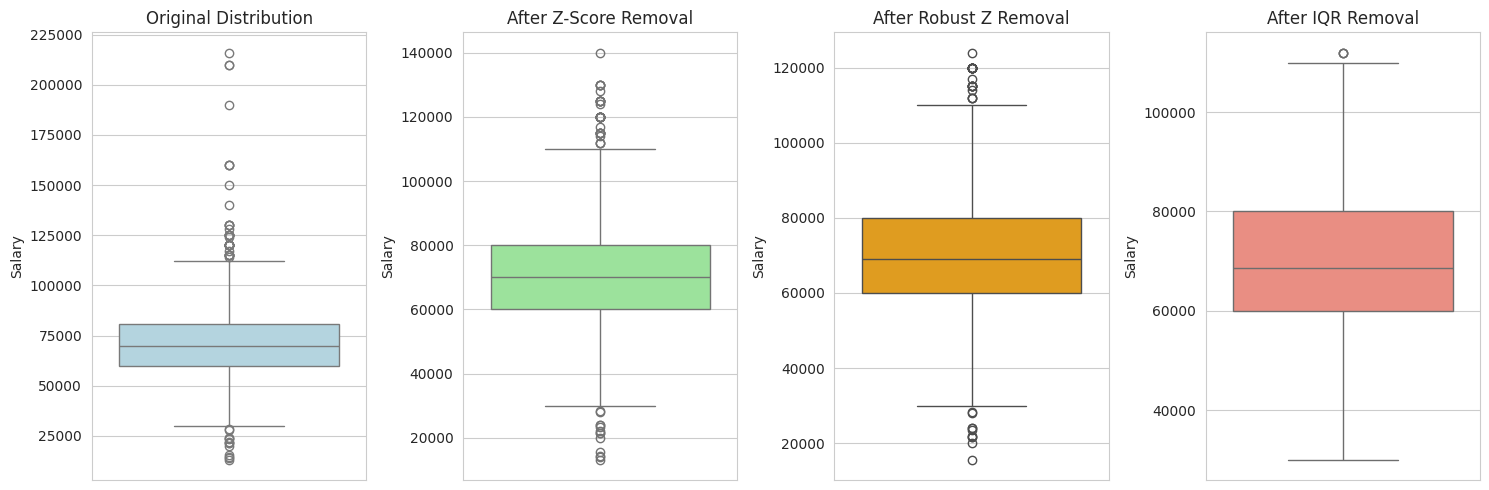

 Application du filtre IQR sur X_train et y_train pour la suite...
Nouvelle taille du dataset Train : (630, 21)


In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

print("\n--- 4. OUTLIER DETECTION ---")

analysis_df = X_train.copy()
analysis_df['Salary'] = y_train

# Colonne à analyser
col_target = 'Salary'
data = analysis_df[col_target].dropna()

# 1. Z-Score (Standard)
z_scores = np.abs(stats.zscore(data))
outliers_z = data[z_scores > 3]

# 2. Robust Z-Score (Median & MAD)
median = np.median(data)
mad = stats.median_abs_deviation(data)
# Formule : 0.6745 * (x - median) / MAD
modified_z_scores = 0.6745 * (data - median) / mad
outliers_robust = data[np.abs(modified_z_scores) > 3.5]

# 3. IQR (Interquartile Range)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = data[(data < lower_bound) | (data > upper_bound)]

# --- Résultats & Questions ---
print(f"Outliers détectés (Z-Score) : {len(outliers_z)}")
print(f"Outliers détectés (Robust Z): {len(outliers_robust)}")
print(f"Outliers détectés (IQR)     : {len(outliers_iqr)}")

# Visualisation (Boxplots)
plt.figure(figsize=(15, 5))

# Avant
plt.subplot(1, 4, 1)
sns.boxplot(y=data, color='lightblue')
plt.title("Original Distribution")

# Après Z-Score
plt.subplot(1, 4, 2)
sns.boxplot(y=data[z_scores <= 3], color='lightgreen')
plt.title("After Z-Score Removal")

# Après Robust
plt.subplot(1, 4, 3)
sns.boxplot(y=data[np.abs(modified_z_scores) <= 3.5], color='orange')
plt.title("After Robust Z Removal")

# Après IQR
plt.subplot(1, 4, 4)
sns.boxplot(y=data[(data >= lower_bound) & (data <= upper_bound)], color='salmon')
plt.title("After IQR Removal")

plt.tight_layout()
plt.show()

print(" Application du filtre IQR sur X_train et y_train pour la suite...")
mask_clean = (y_train >= lower_bound) & (y_train <= upper_bound)
if 'YearsExperience' in X_train.columns:
    q1_exp = X_train['YearsExperience'].quantile(0.25)
    q3_exp = X_train['YearsExperience'].quantile(0.75)
    iqr_exp = q3_exp - q1_exp
    mask_exp = (X_train['YearsExperience'] >= (q1_exp - 1.5*iqr_exp)) & (X_train['YearsExperience'] <= (q3_exp + 1.5*iqr_exp))
    mask_clean = mask_clean & mask_exp

X_train = X_train[mask_clean]
y_train = y_train[mask_clean]
print(f"Nouvelle taille du dataset Train : {X_train.shape}")


--- 5. FEATURE GENERATION ---
Génération automatique des features en cours... (patience)
 Nombre de features générées par Featuretools : 100

Top 5 Corrélations avec Salary :
Salary                                                                                                  1.000000
Log_Salary                                                                                              0.984104
Yearly brutto salary (without bonus and stocks) one year ago. Only answer if staying in same country    0.632683
Exp_Per_Age                                                                                             0.395880
YearsExperience                                                                                         0.372665
Name: Salary, dtype: float64


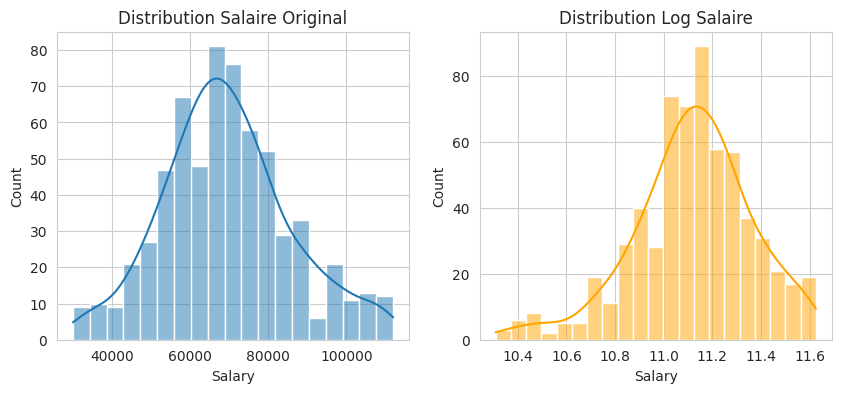

In [40]:
# --- INSTALLATION DES DEPENDANCES ---
# On installe la librairie manquante (le '!' est important dans Colab)
!pip install featuretools
!pip install woodwork

import numpy as np
import pandas as pd
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- 5. FEATURE GENERATION ---")

# 1. Manual Aggregation (Binning Seniority)
X_train['YearsExperience'] = X_train['YearsExperience'].clip(lower=0)
X_train['Seniority_Bin'] = pd.cut(X_train['YearsExperience'],
                                  bins=[-1, 2, 5, 10, 100],
                                  labels=['Junior', 'Mid', 'Senior', 'Expert'])

# 2. Mathematical Transformation (Log Salary)
y_train_log = np.log1p(y_train)

# 3. Combination (Exp / Age)
if 'Age' in X_train.columns:
    X_train['Exp_Per_Age'] = X_train['YearsExperience'] / (X_train['Age'].replace(0, 1))
else:
    print(" Colonne Age introuvable, skip Exp_Per_Age")

# 4. Automated Feature Creation (Featuretools)
print("Génération automatique des features en cours... (patience)")

X_ft = X_train.select_dtypes(include=np.number).copy()
X_ft = X_ft.fillna(0)
X_ft['id'] = range(len(X_ft))

es = ft.EntitySet(id="employees")
es = es.add_dataframe(dataframe_name="data", dataframe=X_ft, index="id")

feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name="data",
                                      trans_primitives=["add_numeric", "multiply_numeric"],
                                      max_depth=1)

print(f" Nombre de features générées par Featuretools : {len(feature_defs)}")

# --- Analyse Corrélation ---
corr_check = X_train.select_dtypes(include=np.number).copy()
corr_check['Salary'] = y_train
corr_check['Log_Salary'] = y_train_log

correlations = corr_check.corr()['Salary'].sort_values(ascending=False)
print("\nTop 5 Corrélations avec Salary :")
print(correlations.head(5))

# Visualisation Log Transform
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True)
plt.title("Distribution Salaire Original")
plt.subplot(1, 2, 2)
sns.histplot(y_train_log, kde=True, color='orange')
plt.title("Distribution Log Salaire")
plt.show()

In [28]:
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

print("\n--- 6. FEATURE SELECTION ---")

# On prépare X numéric (sans NaN) et y
X_sel = X_train.select_dtypes(include=np.number).dropna(axis=1)
if 'id' in X_sel.columns: X_sel = X_sel.drop('id', axis=1)

y_sel = y_train
model = LinearRegression()

# 1. Forward Selection (On ajoute les meilleures une par une)
sfs_fwd = SequentialFeatureSelector(model, n_features_to_select=3, direction='forward')
sfs_fwd.fit(X_sel, y_sel)
feat_fwd = X_sel.columns[sfs_fwd.get_support()].tolist()
print(f"Forward Selection (Top 3): {feat_fwd}")

# 2. Backward Elimination (On enlève les pires une par une)
sfs_bwd = SequentialFeatureSelector(model, n_features_to_select=3, direction='backward')
sfs_bwd.fit(X_sel, y_sel)
feat_bwd = X_sel.columns[sfs_bwd.get_support()].tolist()
print(f"Backward Elimination (Top 3): {feat_bwd}")

# 3. RFE (Recursive Feature Elimination)
rfe = RFE(model, n_features_to_select=3)
rfe.fit(X_sel, y_sel)
feat_rfe = X_sel.columns[rfe.support_].tolist()
print(f"RFE Selected (Top 3): {feat_rfe}")

# Classement RFE
ranking = pd.Series(rfe.ranking_, index=X_sel.columns).sort_values()
print("\nClassement RFE (1 = Meilleur) :")
print(ranking.head(5))


--- 6. FEATURE SELECTION ---
Forward Selection (Top 3): ['Yearly bonus', 'Yearly brutto salary (without bonus and stocks) one year ago. Only answer if staying in same country', 'Exp_Per_Age']
Backward Elimination (Top 3): ['Yearly bonus', 'Yearly brutto salary (without bonus and stocks) one year ago. Only answer if staying in same country', 'Exp_Per_Age']
RFE Selected (Top 3): ['Age', 'YearsExperience', 'Exp_Per_Age']

Classement RFE (1 = Meilleur) :
Age                                     1
YearsExperience                         1
Exp_Per_Age                             1
Number of vacation days                 2
Number of home office days per month    3
dtype: int64


In [41]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

print("\n--- 7. FEATURE ENCODING ---")

# --- AUTO-REPARATION DES COLONNES ---
pos_cols = [c for c in X_train.columns if 'position' in c.lower()]

if 'Position' not in X_train.columns:
    if pos_cols:
        print(f" Correction : Renommage de '{pos_cols[0]}' en 'Position'")
        X_train = X_train.rename(columns={pos_cols[0]: 'Position'})
    else:
        print("Colonne Position introuvable. Création d'une colonne 'Other' par défaut.")
        X_train['Position'] = 'Other'

# 1. Ordinal Encoding
if 'Seniority_Bin' not in X_train.columns:
    X_train['Seniority_Bin'] = pd.cut(X_train['YearsExperience'], bins=[-1, 2, 5, 10, 100], labels=['Junior', 'Mid', 'Senior', 'Expert'])

X_train['Seniority_Bin'] = X_train['Seniority_Bin'].astype(str).replace('nan', 'Junior')

ord_enc = OrdinalEncoder(categories=[['Junior', 'Mid', 'Senior', 'Expert']])
X_train['Seniority_Code'] = ord_enc.fit_transform(X_train[['Seniority_Bin']])

# 2. One-Hot Encoding (Position - Nominal)
top_positions = X_train['Position'].value_counts().nlargest(5).index
X_train['Position_Group'] = X_train['Position'].apply(lambda x: x if x in top_positions else 'Other')

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
pos_ohe = ohe.fit_transform(X_train[['Position_Group']])
pos_labels = ohe.get_feature_names_out(['Position_Group'])

# Affichage du résultat One-Hot
df_pos_ohe = pd.DataFrame(pos_ohe, columns=pos_labels, index=X_train.index)
print(f" One-Hot Encoding terminé. Shape ajoutée : {df_pos_ohe.shape}")

# 3. Target Encoding (City - High Cardinality)
city_col = [c for c in X_train.columns if 'city' in c.lower()]
if city_col:
    real_city_col = city_col[0]
    city_means = y_train.groupby(X_train[real_city_col]).mean()
    X_train['City_TargetEnc'] = X_train[real_city_col].map(city_means)
    X_train['City_TargetEnc'] = X_train['City_TargetEnc'].fillna(y_train.mean())
    print(f" Target Encoding sur '{real_city_col}' terminé.")
else:
    print("Colonne City introuvable, skip Target Encoding.")

print("\nAperçu des colonnes encodées :")
display(X_train[['Seniority_Bin', 'Seniority_Code', 'City_TargetEnc']].head())


--- 7. FEATURE ENCODING ---
 Correction : Renommage de 'Position (without seniority)' en 'Position'
 One-Hot Encoding terminé. Shape ajoutée : (630, 6)
 Target Encoding sur 'City' terminé.

Aperçu des colonnes encodées :


,Seniority_Bin,Seniority_Code,City_TargetEnc
635,Senior,2.0,71644.965278
937,Expert,3.0,70381.055944
573,Senior,2.0,71644.965278
925,Senior,2.0,70381.055944
404,Senior,2.0,70381.055944



--- 8. FEATURE SCALING ---
Features utilisées pour le scaling : ['Age', 'YearsExperience', 'Yearly bonus', 'Yearly stocks', 'Yearly brutto salary (without bonus and stocks) one year ago. Only answer if staying in same country', 'Yearly bonus one year ago. Only answer if staying in same country', 'Yearly stocks one year ago. Only answer if staying in same country', 'Number of vacation days', 'Number of home office days per month', 'Exp_Per_Age', 'Seniority_Code', 'City_TargetEnc']

--- Statistiques ---
Original Mean (ex: Age) : 32.09
Standard Scaler Mean (Doit être ~0)    : 0.00
MinMax Scaler Range (Doit être 0-1)    : 0 à 1


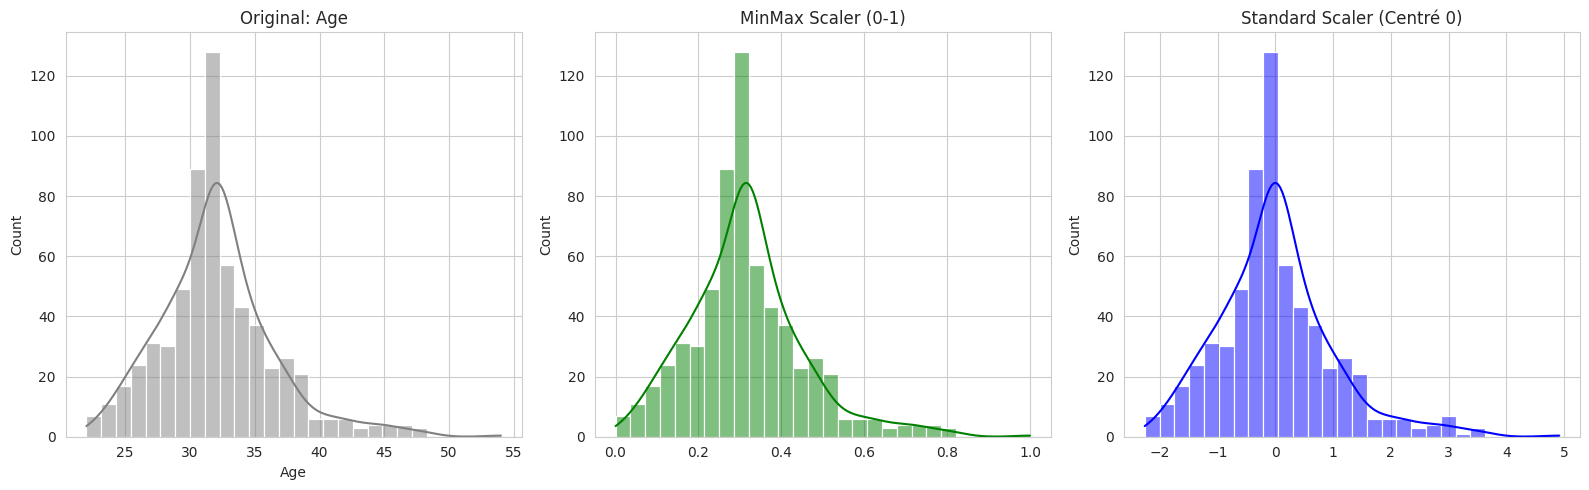


📝 RÉPONSES :
• Quel scaler pour PCA/Neural Networks ? -> StandardScaler.
  (Car PCA cherche la variance max et les NN aiment les données centrées autour de 0).
• Que se passe-t-il si on applique PCA sans scaling ?
  -> Les variables avec de grandes valeurs (ex: Salaire) domineront totalement l'analyse, faussant le résultat.


In [31]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- 8. FEATURE SCALING ---")

# 1. Sélection des colonnes numériques uniquement (sécurité)
X_num = X_train.select_dtypes(include=np.number).dropna(axis=1)

if 'id' in X_num.columns:
    X_num = X_num.drop('id', axis=1)

print(f"Features utilisées pour le scaling : {X_num.columns.tolist()}")

# 2. Application des Scalers
# A. MinMax Scaler (Force les données entre 0 et 1)
mms = MinMaxScaler()
X_mms = mms.fit_transform(X_num)

# B. Standard Scaler (Centre sur 0, Ecart-type de 1)
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X_num)

# C. Normalizer
norm = Normalizer()
X_norm = norm.fit_transform(X_num)

# 3. Comparaison Avant/Après (.describe et Histogrammes)
print("\n--- Statistiques ---")
print(f"Original Mean (ex: {X_num.columns[0]}) : {X_num.iloc[:, 0].mean():.2f}")
print(f"Standard Scaler Mean (Doit être ~0)    : {X_std[:, 0].mean():.2f}")
print(f"MinMax Scaler Range (Doit être 0-1)    : {X_mms.min():.0f} à {X_mms.max():.0f}")

# Visualisation
plt.figure(figsize=(16, 5))

# Plot Original
plt.subplot(1, 3, 1)
sns.histplot(X_num.iloc[:, 0], kde=True, color='gray')
plt.title(f"Original: {X_num.columns[0]}")

# Plot MinMax
plt.subplot(1, 3, 2)
sns.histplot(X_mms[:, 0], kde=True, color='green')
plt.title("MinMax Scaler (0-1)")

# Plot Standard
plt.subplot(1, 3, 3)
sns.histplot(X_std[:, 0], kde=True, color='blue')
plt.title("Standard Scaler (Centré 0)")

plt.tight_layout()
plt.show()

# --- RÉPONSES AUX QUESTIONS ---
print("\n RÉPONSES :")
print("• Quel scaler pour PCA/Neural Networks ? -> StandardScaler.")
print("  (Car PCA cherche la variance max et les NN aiment les données centrées autour de 0).")
print("• Que se passe-t-il si on applique PCA sans scaling ?")
print("  -> Les variables avec de grandes valeurs (ex: Salaire) domineront totalement l'analyse, faussant le résultat.")

# On garde le Standard Scaler pour la suite
X_final = X_std


--- 9. PCA (Principal Component Analysis) ---
✅ Nombre de composants pour expliquer 90% de la variance : 9


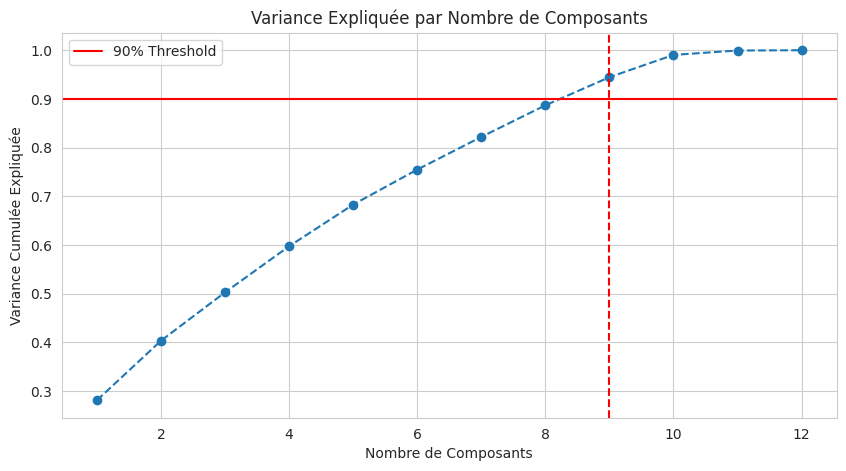

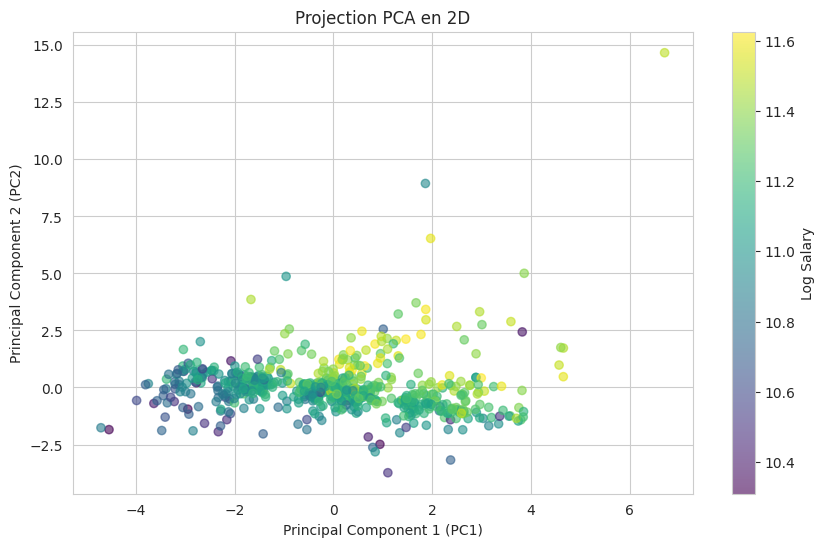

Shape Originale : (630, 12)
Shape Reconstruite (depuis 2D) : (630, 12)

📝 QUELLES FEATURES COMPTENT LE PLUS ?
Top 3 Features contribuant au Premier Composant (PC1) :
YearsExperience    0.520507
Seniority_Code     0.507505
Exp_Per_Age        0.506236
dtype: float64


In [32]:
from sklearn.decomposition import PCA

print("\n--- 9. PCA (Principal Component Analysis) ---")

# 1. Application de la PCA
pca_full = PCA()
pca_full.fit(X_final)

# Calcul de la variance cumulée
cumsum = np.cumsum(pca_full.explained_variance_ratio_)

# Trouver combien de composants expliquent 90% de la variance
d_90 = np.argmax(cumsum >= 0.90) + 1

print(f"Nombre de composants pour expliquer 90% de la variance : {d_90}")

# 2. Plot Explained Variance Ratio (Courbe "Coude")
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumsum) + 1), cumsum, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='-', label='90% Threshold')
plt.axvline(x=d_90, color='r', linestyle='--')
plt.xlabel('Nombre de Composants')
plt.ylabel('Variance Cumulée Expliquée')
plt.title('Variance Expliquée par Nombre de Composants')
plt.legend()
plt.grid(True)
plt.show()

# 3. Visualisation 2D (Premiers 2 composants)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_final)

plt.figure(figsize=(10, 6))
# On colore par le log du salaire pour voir si le salaire est bien séparé
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=np.log1p(y_train), cmap='viridis', alpha=0.6)
plt.colorbar(label='Log Salary')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('Projection PCA en 2D')
plt.show()

# 4. Reconstruction des données (Inverse Transform)
X_reconstructed = pca_2d.inverse_transform(X_pca_2d)
print(f"Shape Originale : {X_final.shape}")
print(f"Shape Reconstruite (depuis 2D) : {X_reconstructed.shape}")

# 5. Contribution des features au premier composant (PC1)
print("\n📝 QUELLES FEATURES COMPTENT LE PLUS ?")
pc1_loading = np.abs(pca_2d.components_[0])
feature_importance = pd.Series(pc1_loading, index=X_num.columns).sort_values(ascending=False)

print("Top 3 Features contribuant au Premier Composant (PC1) :")
print(feature_importance.head(3))